In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/tmdb-box-office-prediction/test.csv
/kaggle/input/tmdb-box-office-prediction/train.csv
/kaggle/input/tmdb-box-office-prediction/sample_submission.csv
/kaggle/input/tmdb-competition-additional-features/TrainAdditionalFeatures.csv
/kaggle/input/tmdb-competition-additional-features/TestAdditionalFeatures.csv
/kaggle/input/tmdb-competition-additional-features-2/additionalData.csv


In [2]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
stop = set(stopwords.words('english'))
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import json
import ast
import eli5
import shap
from catboost import CatBoostRegressor
from urllib.request import urlopen
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

/opt/conda/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.

Using TensorFlow backend.


In [3]:
trainAdditionalFeatures = pd.read_csv('../input/tmdb-competition-additional-features/TrainAdditionalFeatures.csv')
testAdditionalFeatures = pd.read_csv('../input/tmdb-competition-additional-features/TestAdditionalFeatures.csv')

train = pd.read_csv('../input/tmdb-box-office-prediction/train.csv')
test = pd.read_csv('../input/tmdb-box-office-prediction/test.csv')

train = pd.merge(train, trainAdditionalFeatures, how='left', on=['imdb_id'])
test = pd.merge(test, testAdditionalFeatures, how='left', on=['imdb_id'])
test['revenue'] = -np.inf
train.loc[train['id'] == 16,'revenue'] = 192864          # Skinning
train.loc[train['id'] == 90,'budget'] = 30000000         # Sommersby          
train.loc[train['id'] == 118,'budget'] = 60000000        # Wild Hogs
train.loc[train['id'] == 149,'budget'] = 18000000        # Beethoven
train.loc[train['id'] == 313,'revenue'] = 12000000       # The Cookout 
train.loc[train['id'] == 451,'revenue'] = 12000000       # Chasing Liberty
train.loc[train['id'] == 464,'budget'] = 20000000        # Parenthood
train.loc[train['id'] == 470,'budget'] = 13000000        # The Karate Kid, Part II
train.loc[train['id'] == 513,'budget'] = 930000          # From Prada to Nada
train.loc[train['id'] == 797,'budget'] = 8000000         # Welcome to Dongmakgol
train.loc[train['id'] == 819,'budget'] = 90000000        # Alvin and the Chipmunks: The Road Chip
train.loc[train['id'] == 850,'budget'] = 90000000        # Modern Times
train.loc[train['id'] == 1007,'budget'] = 2              # Zyzzyx Road 
train.loc[train['id'] == 1112,'budget'] = 7500000        # An Officer and a Gentleman
train.loc[train['id'] == 1131,'budget'] = 4300000        # Smokey and the Bandit   
train.loc[train['id'] == 1359,'budget'] = 10000000       # Stir Crazy 
train.loc[train['id'] == 1542,'budget'] = 1              # All at Once
train.loc[train['id'] == 1570,'budget'] = 15800000       # Crocodile Dundee II
train.loc[train['id'] == 1571,'budget'] = 4000000        # Lady and the Tramp
train.loc[train['id'] == 1714,'budget'] = 46000000       # The Recruit
train.loc[train['id'] == 1721,'budget'] = 17500000       # Cocoon
train.loc[train['id'] == 1865,'revenue'] = 25000000      # Scooby-Doo 2: Monsters Unleashed
train.loc[train['id'] == 1885,'budget'] = 12             # In the Cut
train.loc[train['id'] == 2091,'budget'] = 10             # Deadfall
train.loc[train['id'] == 2268,'budget'] = 17500000       # Madea Goes to Jail budget
train.loc[train['id'] == 2491,'budget'] = 6              # Never Talk to Strangers
train.loc[train['id'] == 2602,'budget'] = 31000000       # Mr. Holland's Opus
train.loc[train['id'] == 2612,'budget'] = 15000000       # Field of Dreams
train.loc[train['id'] == 2696,'budget'] = 10000000       # Nurse 3-D
train.loc[train['id'] == 2801,'budget'] = 10000000       # Fracture
train.loc[train['id'] == 335,'budget'] = 2 
train.loc[train['id'] == 348,'budget'] = 12
train.loc[train['id'] == 470,'budget'] = 13000000 
train.loc[train['id'] == 513,'budget'] = 1100000
train.loc[train['id'] == 640,'budget'] = 6 
train.loc[train['id'] == 696,'budget'] = 1
train.loc[train['id'] == 797,'budget'] = 8000000 
train.loc[train['id'] == 850,'budget'] = 1500000
train.loc[train['id'] == 1199,'budget'] = 5 
train.loc[train['id'] == 1282,'budget'] = 9               # Death at a Funeral
train.loc[train['id'] == 1347,'budget'] = 1
train.loc[train['id'] == 1755,'budget'] = 2
train.loc[train['id'] == 1801,'budget'] = 5
train.loc[train['id'] == 1918,'budget'] = 592 
train.loc[train['id'] == 2033,'budget'] = 4
train.loc[train['id'] == 2118,'budget'] = 344 
train.loc[train['id'] == 2252,'budget'] = 130
train.loc[train['id'] == 2256,'budget'] = 1 
train.loc[train['id'] == 2696,'budget'] = 10000000

#Clean Data
test.loc[test['id'] == 6733,'budget'] = 5000000
test.loc[test['id'] == 3889,'budget'] = 15000000
test.loc[test['id'] == 6683,'budget'] = 50000000
test.loc[test['id'] == 5704,'budget'] = 4300000
test.loc[test['id'] == 6109,'budget'] = 281756
test.loc[test['id'] == 7242,'budget'] = 10000000
test.loc[test['id'] == 7021,'budget'] = 17540562       #  Two Is a Family
test.loc[test['id'] == 5591,'budget'] = 4000000        # The Orphanage
test.loc[test['id'] == 4282,'budget'] = 20000000       # Big Top Pee-wee
test.loc[test['id'] == 3033,'budget'] = 250 
test.loc[test['id'] == 3051,'budget'] = 50
test.loc[test['id'] == 3084,'budget'] = 337
test.loc[test['id'] == 3224,'budget'] = 4  
test.loc[test['id'] == 3594,'budget'] = 25  
test.loc[test['id'] == 3619,'budget'] = 500  
test.loc[test['id'] == 3831,'budget'] = 3  
test.loc[test['id'] == 3935,'budget'] = 500  
test.loc[test['id'] == 4049,'budget'] = 995946 
test.loc[test['id'] == 4424,'budget'] = 3  
test.loc[test['id'] == 4460,'budget'] = 8  
test.loc[test['id'] == 4555,'budget'] = 1200000 
test.loc[test['id'] == 4624,'budget'] = 30 
test.loc[test['id'] == 4645,'budget'] = 500 
test.loc[test['id'] == 4709,'budget'] = 450 
test.loc[test['id'] == 4839,'budget'] = 7
test.loc[test['id'] == 3125,'budget'] = 25 
test.loc[test['id'] == 3142,'budget'] = 1
test.loc[test['id'] == 3201,'budget'] = 450
test.loc[test['id'] == 3222,'budget'] = 6
test.loc[test['id'] == 3545,'budget'] = 38
test.loc[test['id'] == 3670,'budget'] = 18
test.loc[test['id'] == 3792,'budget'] = 19
test.loc[test['id'] == 3881,'budget'] = 7
test.loc[test['id'] == 3969,'budget'] = 400
test.loc[test['id'] == 4196,'budget'] = 6
test.loc[test['id'] == 4221,'budget'] = 11
test.loc[test['id'] == 4222,'budget'] = 500
test.loc[test['id'] == 4285,'budget'] = 11
test.loc[test['id'] == 4319,'budget'] = 1
test.loc[test['id'] == 4639,'budget'] = 10
test.loc[test['id'] == 4719,'budget'] = 45
test.loc[test['id'] == 4822,'budget'] = 22
test.loc[test['id'] == 4829,'budget'] = 20
test.loc[test['id'] == 4969,'budget'] = 20
test.loc[test['id'] == 5021,'budget'] = 40 
test.loc[test['id'] == 5035,'budget'] = 1 
test.loc[test['id'] == 5063,'budget'] = 14 
test.loc[test['id'] == 5119,'budget'] = 2 
test.loc[test['id'] == 5214,'budget'] = 30 
test.loc[test['id'] == 5221,'budget'] = 50 
test.loc[test['id'] == 4903,'budget'] = 15
test.loc[test['id'] == 4983,'budget'] = 3
test.loc[test['id'] == 5102,'budget'] = 28
test.loc[test['id'] == 5217,'budget'] = 75
test.loc[test['id'] == 5224,'budget'] = 3 
test.loc[test['id'] == 5469,'budget'] = 20 
test.loc[test['id'] == 5840,'budget'] = 1 
test.loc[test['id'] == 5960,'budget'] = 30
test.loc[test['id'] == 6506,'budget'] = 11 
test.loc[test['id'] == 6553,'budget'] = 280
test.loc[test['id'] == 6561,'budget'] = 7
test.loc[test['id'] == 6582,'budget'] = 218
test.loc[test['id'] == 6638,'budget'] = 5
test.loc[test['id'] == 6749,'budget'] = 8 
test.loc[test['id'] == 6759,'budget'] = 50 
test.loc[test['id'] == 6856,'budget'] = 10
test.loc[test['id'] == 6858,'budget'] =  100
test.loc[test['id'] == 6876,'budget'] =  250
test.loc[test['id'] == 6972,'budget'] = 1
test.loc[test['id'] == 7079,'budget'] = 8000000
test.loc[test['id'] == 7150,'budget'] = 118
test.loc[test['id'] == 6506,'budget'] = 118
test.loc[test['id'] == 7225,'budget'] = 6
test.loc[test['id'] == 7231,'budget'] = 85
test.loc[test['id'] == 5222,'budget'] = 5
test.loc[test['id'] == 5322,'budget'] = 90
test.loc[test['id'] == 5350,'budget'] = 70
test.loc[test['id'] == 5378,'budget'] = 10
test.loc[test['id'] == 5545,'budget'] = 80
test.loc[test['id'] == 5810,'budget'] = 8
test.loc[test['id'] == 5926,'budget'] = 300
test.loc[test['id'] == 5927,'budget'] = 4
test.loc[test['id'] == 5986,'budget'] = 1
test.loc[test['id'] == 6053,'budget'] = 20
test.loc[test['id'] == 6104,'budget'] = 1
test.loc[test['id'] == 6130,'budget'] = 30
test.loc[test['id'] == 6301,'budget'] = 150
test.loc[test['id'] == 6276,'budget'] = 100
test.loc[test['id'] == 6473,'budget'] = 100
test.loc[test['id'] == 6842,'budget'] = 30

# from this kernel: https://www.kaggle.com/gravix/gradient-in-a-box
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df
        
train = text_to_dict(train)
test = text_to_dict(test)

def fix_date(x):
    """
    Fixes dates which are in 20xx
    """
    if not isinstance(x, str): return x
    year = x.split('/')[2]
    if int(year) <= 19:
        return x[:-2] + '20' + year
    else:
        return x[:-2] + '19' + year

train.loc[train['release_date'].isnull() == True, 'release_date'] = '01/01/19'
test.loc[test['release_date'].isnull() == True, 'release_date'] = '01/01/19'
    
#train["RevByBud"] = train["revenue"] / train["budget"]
    
train['release_date'] = train['release_date'].apply(lambda x: fix_date(x))
test['release_date'] = test['release_date'].apply(lambda x: fix_date(x))


In [4]:
train.columns


Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue',
       'popularity2', 'rating', 'totalVotes'],
      dtype='object')

In [5]:
train['genres']

0                          [{'id': 35, 'name': 'Comedy'}]
1       [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
2                           [{'id': 18, 'name': 'Drama'}]
3       [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...
4       [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...
                              ...                        
2995    [{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...
2996    [{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...
2997    [{'id': 80, 'name': 'Crime'}, {'id': 28, 'name...
2998    [{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...
2999    [{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...
Name: genres, Length: 3000, dtype: object

In [6]:
def DicCol2OneHot (df,ColName):
    ColumnDic = {}
    # Create Combined Dictionary
    for ColDictionaty in df[ColName]:
        for Value in ColDictionaty:
            ColumnDic[Value['id']] = Value['name']
    # Create Empty Columns
    for Value in ColumnDic:
        ValueName = ColName + '_' + str(Value)
        df[ValueName] = 0
    for line in df.index:
        for Value in df.loc[line,ColName]:
            ValueName = ColName + '_' + str(Value['id'])
            df.loc[line,ValueName] = 1
    return ColumnDic, df

In [7]:
genres_dic = {}
genres_dic, train = DicCol2OneHot(train, 'genres')

In [8]:
train

id                              belongs_to_collection    budget  \
0        1  [{'id': 313576, 'name': 'Hot Tub Time Machine ...  14000000   
1        2  [{'id': 107674, 'name': 'The Princess Diaries ...  40000000   
2        3                                                 {}   3300000   
3        4                                                 {}   1200000   
4        5                                                 {}         0   
...    ...                                                ...       ...   
2995  2996                                                 {}         0   
2996  2997                                                 {}         0   
2997  2998                                                 {}  65000000   
2998  2999                                                 {}  42000000   
2999  3000                                                 {}  35000000   

                                                 genres  \
0                        [{'id': 35, 'name': 'Comedy'}]   
1     [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
2                         [{'id': 18, 'name': 'Drama'}]   
3     [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...   
4     [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...   
...                                                 ...   
2995  [{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...   
2996  [{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...   
2997  [{'id': 80, 'name': 'Crime'}, {'id': 28, 'name...   
2998  [{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...   
2999  [{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...   

                               homepage    imdb_id original_language  \
0                                   NaN  tt2637294                en   
1                                   NaN  tt0368933                en   
2     http://sonyclassics.com/whiplash/  tt2582802                en   
3            http://kahaanithefilm.com/  tt1821480                hi   
4                                   NaN  tt1380152                ko   
...                                 ...        ...               ...   
2995                                NaN  tt0109403                en   
2996                                NaN  tt2364975                sv   
2997                                NaN  tt0116908                en   
2998     http://www.alongcamepolly.com/  tt0343135                en   
2999   http://www.abductionthefilm.com/  tt1600195                en   

                                original_title  \
0                       Hot Tub Time Machine 2   
1     The Princess Diaries 2: Royal Engagement   
2                                     Whiplash   
3                                      Kahaani   
4                                         마린보이   
...                                        ...   
2995                                   Chasers   
2996                               Vi är bäst!   
2997                   The Long Kiss Goodnight   
2998                          Along Came Polly   
2999                                 Abduction   

                                               overview  popularity  \
0     When Lou, who has become the "father of the In...    6.575393   
1     Mia Thermopolis is now a college graduate and ...    8.248895   
2     Under the direction of a ruthless instructor, ...   64.299990   
3     Vidya Bagchi (Vidya Balan) arrives in Kolkata ...    3.174936   
4     Marine Boy is the story of a former national s...    1.148070   
...                                                 ...         ...   
2995  Military men Rock Reilly and Eddie Devane are ...    9.853270   
2996  Three girls in 1980s Stockholm decide to form ...    3.727996   
2997  Samantha Caine, suburban homemaker, is the ide...   14.482345   
2998  Reuben Feffer is a guy who's spent his entire ...   15.725542   
2999  A young man sets out to uncover the truth abou...   10.512109   

                           poster_path  \
0     /tQtWuwvMf0hCc2QR2tkolwl7c3c.jp

In [9]:

genres_dic = {}
for genres in train.genres:
    for genre in genres:
        genres_dic[genre['id']] = genre['name']
genres_dic
# create columns
for genre  in genres_dic.keys():
    genre_name = 'genre_' + str(genre)
    train[genre_name]  = np.NaN
for line in train.index:
#    print(line)
    for genre in train.loc[line,'genres']:
        genre_name = 'genre_' + str(genre['id'])
        train.loc[line,genre_name] = 1


In [10]:
genre['id']

9648

In [11]:
train[['genres_35', 'genres_18',
       'genres_10751', 'genres_10749', 'genres_53', 'genres_28', 'genres_16',
       'genres_12', 'genres_27', 'genres_99', 'genres_10402', 'genres_80',
       'genres_878', 'genres_9648', 'genres_10769', 'genres_14', 'genres_10752',
       'genres_37', 'genres_36', 'genres_10770']]





genres_35  genres_18  genres_10751  genres_10749  genres_53  genres_28  \
0             1          0             0             0          0          0   
1             1          1             1             1          0          0   
2             0          1             0             0          0          0   
3             0          1             0             0          1          0   
4             0          0             0             0          1          1   
...         ...        ...           ...           ...        ...        ...   
2995          1          0             0             1          0          0   
2996          0          1             0             0          0          0   
2997          0          0             0             0          1          1   
2998          1          0             0             1          0          0   
2999          0          0             0             0          1          1   

      genres_16  genres_12  genres_27  genres_99  genres_10402  genres_80  \
0             0          0          0          0             0          0   
1             0          0          0          0             0          0   
2             0          0          0          0             0          0   
3             0          0          0          0             0          0   
4             0          0          0          0             0          0   
...         ...        ...        ...        ...           ...        ...   
2995          0          0          0          0             0          0   
2996          0          0          0          0             1          0   
2997          0          0          0          0             0          1   
2998          0          0          0          0             0          0   
2999          0          0          0          0             0          0   

      genres_878  genres_9648  genres_10769  genres_14  genres_10752  \
0              0            0             0          0             0   
1              0            0             0          0             0   
2              0            0             0          0             0   
3              0            0             0          0             0   
4              0            0             0          0             0   
...          ...          ...           ...        ...           ...   
2995           0            0             0          0             0   
2996           0            0             0          0             0   
2997           0            1             0          0             0   
2998           0            0             0          0             0   
2999           0            1             0          0             0   

      genres_37  genres_36  genres_10770  
0             0          0             0  
1             0          0             0  
2             0          0             0  
3             0          0             0  
4             0          0             0  
...         ...        ...           ...  
2995          0          0             0  
2996          0          0             0  
2997          0          0             0  
2998          0          0             0  
2999          0          0             0  

[3000 rows x 20 columns]

In [12]:
def convert_date (df):
    df['Date_release'] = df.apply(lambda x: datetime.datetime.strptime(x['release_date'], "%m/%d/%Y").date() ,axis = 1)
    df['Year_release'] = df.apply(lambda x: x['Date_release'].year,axis=1)
    df['Month_release'] = df.apply(lambda x: x['Date_release'].month,axis=1)
    df['Day_release'] = df.apply(lambda x: x['Date_release'].day,axis=1)
    df['WeekDay_release'] = df.apply(lambda x: x['Date_release'].weekday(),axis=1)
    

In [13]:
convert_date (train)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 2999
Data columns (total 71 columns):
id                       3000 non-null int64
belongs_to_collection    3000 non-null object
budget                   3000 non-null int64
genres                   3000 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     3000 non-null object
production_countries     3000 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         3000 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords            

In [14]:
time_Dim = ['Date_release','Year_release','Month_release','WeekDay_release','Day_release']
train [time_Dim]

train['profit_value'] = train.revenue - train.budget 

In [15]:
train['profit_value'].describe()

count    3.000000e+03
mean     4.402041e+07
std      1.121730e+08
min     -1.074474e+08
25%      1.770425e+04
50%      6.103544e+06
75%      4.130289e+07
max      1.316249e+09
Name: profit_value, dtype: float64

In [16]:
#fig, saxis = plt.subplots(1, 2,figsize=(16,12))

for timeslice in time_Dim:
    print(train.groupby(by=timeslice).mean()['profit_value'])

#plt.bar()
#sns.barplot(x = 'Year_release', y = 'revenue', data=train, ax = saxis[0,0])
#sns.barplot(x = 'Month_release', y = 'revenue',  data=train, ax = saxis[0,1])
#sns.barplot(x = 'genres', y = 'revenue', order=[1,0], data=train, ax = saxis[0,2])

#sns.pointplot(x = 'FareBin', y = 'revenue',  data=data1, ax = saxis[1,0])
#sns.pointplot(x = 'AgeBin', y = 'revenue',  data=data1, ax = saxis[1,1])

#sns.pointplot(x = 'FamilySize', y = 'revenue', data=data1, ax = saxis[1,2])

Date_release
1921-01-21      2250000.0
1924-03-18        78226.0
1925-08-26         -591.0
1925-12-24        45100.0
1926-05-14       503423.0
                 ...     
2017-06-23     14942939.0
2017-06-28    190511319.0
2017-06-29          422.0
2017-07-11    217907963.0
2017-07-20   -107447384.0
Name: profit_value, Length: 2398, dtype: float64
Year_release
1921    2.250000e+06
1924    7.822600e+04
1925    2.225450e+04
1926    5.034230e+05
1927    2.723875e+05
            ...     
2013    4.522319e+07
2014    5.331462e+07
2015    7.352779e+07
2016    5.111602e+07
2017    1.285891e+08
Name: profit_value, Length: 90, dtype: float64
Month_release
1     1.609935e+07
2     3.918306e+07
3     4.752320e+07
4     3.931659e+07
5     6.182321e+07
6     8.954517e+07
7     6.601561e+07
8     2.386844e+07
9     2.236918e+07
10    2.361733e+07
11    5.059101e+07
12    6.594199e+07
Name: profit_value, dtype: float64
WeekDay_release
0    5.690555e+07
1    6.794519e+07
2    7.979005e+07
3    5.012868e

In [17]:
type(train.belongs_to_collection)

pandas.core.series.Series

In [18]:
# lists: 
#lists = ['belongs_to_collection','genres','production_companies', 'production_countries', 'spoken_languages','Keywords','cast', 'crew']
group_by = [ 'budget',  'homepage',
       'original_language', 'popularity', 'runtime', 
       'status', 'tagline', 'title',   
       'popularity2', 'rating', 'totalVotes', 'Date_release', 'Year_release',
       'Month_release']

for col in group_by:
    print(f'{col} :\n')
    print(train.groupby(by=col).mean()['revenue'])

budget :

budget
0            9.533039e+06
1            2.750000e+01
2            1.133333e+01
4            2.500000e+01
5            1.100000e+02
                 ...     
260000000    4.445406e+08
270000000    3.910812e+08
280000000    1.405404e+09
300000000    9.610000e+08
380000000    1.045714e+09
Name: revenue, Length: 406, dtype: float64
homepage :

homepage
http://3bogatirya.ru/                                19010585.0
http://500days.com                                   60722734.0
http://DontThinkTwiceMovie.com                        4417667.0
http://abandcalleddeath.com/                              125.0
http://admiralfilm.ru/                               38135878.0
                                                       ...     
https://www.uphe.com/movies/a-dogs-purpose          194647323.0
https://www.uphe.com/movies/legend-1986              15502112.0
https://www.uphe.com/movies/the-bourne-supremacy    288500217.0
https://www.uphe.com/movies/the-wedding-date         4717

In [19]:
lists = ['title','Collection_Name','belongs_to_collection','genres','production_companies', 'production_countries', 'spoken_languages','Keywords','cast', 'crew']
train['Collection_Name'] = train.apply(lambda x: '' if len(x['belongs_to_collection']) == 0 else x['belongs_to_collection'][0]['name'] ,axis=1)
train [lists]



title  \
0                       Hot Tub Time Machine 2   
1     The Princess Diaries 2: Royal Engagement   
2                                     Whiplash   
3                                      Kahaani   
4                                   Marine Boy   
...                                        ...   
2995                                   Chasers   
2996                          We Are the Best!   
2997                   The Long Kiss Goodnight   
2998                          Along Came Polly   
2999                                 Abduction   

                      Collection_Name  \
0     Hot Tub Time Machine Collection   
1     The Princess Diaries Collection   
2                                       
3                                       
4                                       
...                               ...   
2995                                    
2996                                    
2997                                    
2998                                    
2999                                    

                                  belongs_to_collection  \
0     [{'id': 313576, 'name': 'Hot Tub Time Machine ...   
1     [{'id': 107674, 'name': 'The Princess Diaries ...   
2                                                    {}   
3                                                    {}   
4                                                    {}   
...                                                 ...   
2995                                                 {}   
2996                                                 {}   
2997                                                 {}   
2998                                                 {}   
2999                                                 {}   

                                                 genres  \
0                        [{'id': 35, 'name': 'Comedy'}]   
1     [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
2                         [{'id': 18, 'name': 'Drama'}]   
3     [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...   
4     [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...   
...                                                 ...   
2995  [{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...   
2996  [{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...   
2997  [{'id': 80, 'name': 'Crime'}, {'id': 28, 'name...   
2998  [{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...   
2999  [{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...   

                                   production_companies  \
0     [{'name': 'Paramount Pictures', 'id': 4}, {'na...   
1           [{'name': 'Walt Disney Pictures', 'id': 2}]   
2     [{'name': 'Bold Films', 'id': 2266}, {'name': ...   
3                                                    {}   
4                                                    {}   
...                                                 ...   
2995  [{'name': 'Warner Bros.', 'id': 6194}, {'name'...   
2996  [{'name': 'Memfis Film', 'id': 321}, {'name': ...   
2997  [{'name': 'New Line Cinema', 'id': 12}, {'name...   
2998  [{'name': 'Jersey Films', 'id': 216}, {'name':...   
2999  [{'name': 'Lions Gate Films', 'id': 35}, {'nam...   

                                   production_countries  \
0     [{'iso_3166_1': 'US', 'name': 'United States o...   
1     [{'iso_3166_1': 'US', 'name': 'United States o...   
2     [{'iso_3166_1': 'US', 'name': 'United States o...   
3               [{'iso_3166_1': 'IN', 'name': 'India'}]   
4         [{'iso_3166_1': 'KR', 'name': 'South Korea'}]   
...                                                 ...   
2995  [{'iso_3166_1': 'US', 'name': 'United States o...   
2996  [{'iso_3166_1': 'DK', 'name': 'Denmark'}, {'is...   
2997  [{'iso_3166_1': 'US', 'name': 'United States o...   
2998  [{'iso_3166_1': 'US', 'name': 'United States o...   
2999  [{'iso_3166_1': 'US', 'name': 'United States o...   

                                       spoken_languages  \
0              [{'iso_639_1': 'en', 'name': 'English

In [20]:
train['belongs_to_collection'][0][0]['name']

'Hot Tub Time Machine Collection'

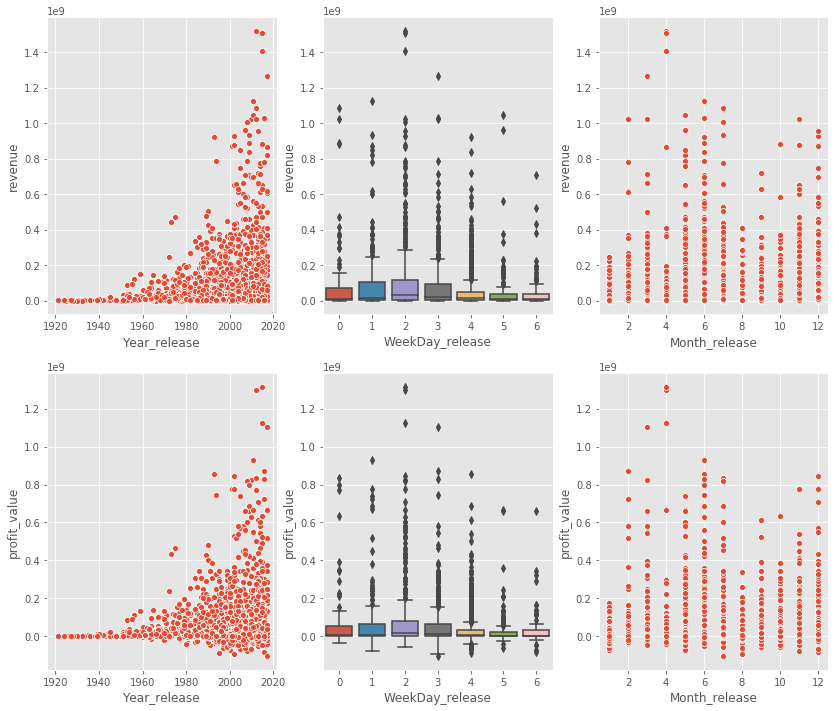

In [21]:
fig, ((axis1,axis2,axis3),(axis4,axis5,axis6)) = plt.subplots(2,3,figsize=(14,12))

sns.scatterplot(x = train['Year_release'], y = train['revenue'],ax = axis1)
sns.boxplot(x = train['WeekDay_release'], y = train['revenue'], ax = axis2)
sns.scatterplot(x = train['Month_release'], y = train['revenue'], ax = axis3)
sns.scatterplot(x = train['Year_release'], y = train['profit_value'],ax = axis4)
sns.boxplot(x = train['WeekDay_release'], y = train['profit_value'], ax = axis5)
sns.scatterplot(x = train['Month_release'], y = train['profit_value'], ax = axis6)

#axis1.set_title('Pclass vs Fare Survival Comparison')

#sns.violinplot(x = 'Pclass', y = 'Age', hue = 'Survived', data = data1, split = True, ax = axis2)
#axis2.set_title('Pclass vs Age Survival Comparison')

#sns.boxplot(x = 'Pclass', y ='FamilySize', hue = 'Survived', data = data1, ax = axis3)
#axis3.set_title('Pclass vs Family Size Survival Comparison')

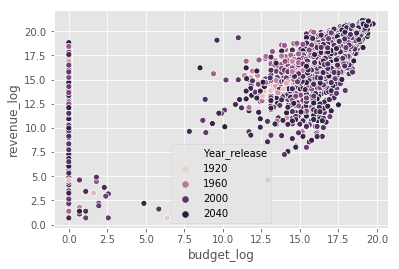

In [22]:
import math
train['budget_log'] = np.log1p(train['budget'])
train['revenue_log'] = np.log1p(train['revenue'])

sns.scatterplot(x = train['budget_log'],y = train['revenue_log'],hue=train['Year_release'])

In [23]:
sns.pairplot(train)

/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning:

invalid value encountered in greater_equal

/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning:

invalid value encountered in less_equal



In [24]:
train.genres

0                          [{'id': 35, 'name': 'Comedy'}]
1       [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
2                           [{'id': 18, 'name': 'Drama'}]
3       [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...
4       [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...
                              ...                        
2995    [{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...
2996    [{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...
2997    [{'id': 80, 'name': 'Crime'}, {'id': 28, 'name...
2998    [{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...
2999    [{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...
Name: genres, Length: 3000, dtype: object

In [25]:
#create genres list
